# Chinese document Classification

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

# Overview of Task

## 1. Load data

In [57]:
data_path = 'data/zh_news/test.csv'

In [58]:
data = pd.read_csv(data_path, names=['label', 'title', 'content'])
data.head()

,label,title,content
0,1,ti3 ca1o shi4 jie4 be1i : che2ng fe1i na2 pi2...,su4 du4 : ( shuo1 mi2ng : dia3n ji1 zi4 do4ng ...
1,4,da3o ha2ng,du2 jia1 ti2 go1ng me3i ri4 ba4o jia4 \n re4 ...
2,1,wa3ng yi4 ti3 yu4,gu3n do4ng tu2 ji2 \n be3n tu2 ji2 go4ng 7 zh...
3,3,zi1 lia4o tu2 pia4n : dia4n shi4 ju4 < fu2 gu...,wa3ng ye4 \n bu4 zhi1 chi2 Flash\n xi1n la4n...
4,2,niu3 yua2n dui4 me3i yua2n : ku4 lu2n jia3ng ...,xi1n xi1 la2n ca2i cha2ng ku4 lu2n fa1 bia3o j...


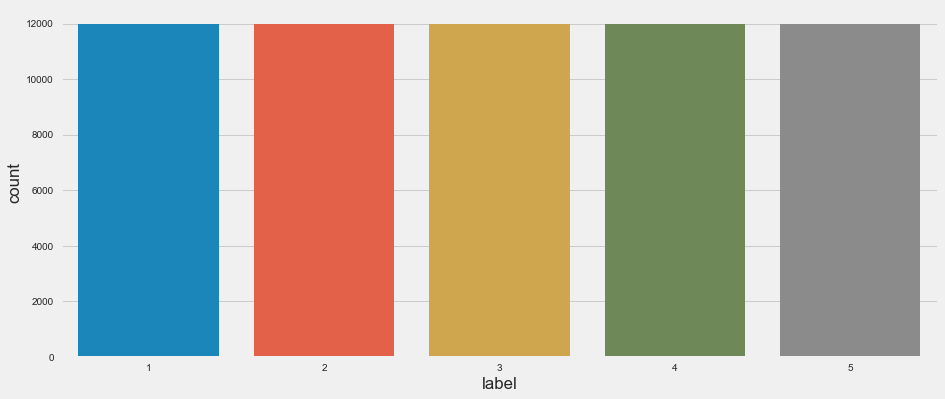

In [59]:
sns.countplot(data['label'])

## 2. Build vocab

In [60]:
chars = 'abcdefghijklmnopqrstuvwxyz-,;!?:\'\\|_@#$%ˆ&*˜‘+-=<>()[]{} '
char_to_index = {char:i for i, char in enumerate(chars)}
index_to_char = {i: char for i, char in enumerate(chars)}

## 3. Find max sequence length

In [61]:
maxlen = int(max(data['title'].apply(len)))
maxlen

207

## 4. Convert sequences to Tensors

In [156]:
def encode_input(title, maxlen=207):
    title = title.lower().strip()
    encoding = np.zeros((len(chars), maxlen), dtype=np.int64)
    for i, char in enumerate(title[:maxlen]):
        index = char_to_index.get(char, 'unknown')
        if index is not 'unknown':
            encoding[index,i] = 1
    return encoding

In [157]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [158]:
encode_input('Brian')

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [159]:
encode_input('Brian').shape

(57, 207)

## 5. Build PyTorch Dataset and DataLoader

In [164]:
from torch.utils.data import Dataset, DataLoader

In [167]:
class SogouNews(Dataset):
    """Sogou News dataset"""
    
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path, names=['label', 'title', 'content']).dropna()
        del self.data['content']
        self.X = self.data['title']
        self.y = self.data['label']
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        content = torch.from_numpy(quantize_line(self.data['title'][index])).float()
        label = self.data['label'][index] - 1
        sample = {'X': content, 'y': label}
        return sample

In [168]:
sogou_dataset = SogouNews(data_path)

In [169]:
dataloader = DataLoader(sogou_dataset, batch_size=32, shuffle=True, num_workers=0)

In [170]:
test_batch = next(iter(dataloader))
test_batch['X'][0]


    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     1  ...      0     0     0
[torch.FloatTensor of size 57x207]

# Define Model

In [171]:
class CharCNN(nn.Module):    
    def __init__(self, n_classes, vocab_size, max_seq_length, channel_size=128, pool_size=5):
        
        super(CharCNN, self).__init__()
    
        self.conv_stack = nn.ModuleList([nn.Conv1d(vocab_size, channel_size, 7), 
                                         nn.ReLU(),
                                         nn.BatchNorm1d(num_features=channel_size),
                                         nn.MaxPool1d(pool_size),
                                         nn.Conv1d(channel_size, channel_size, 3, padding=1),
                                         nn.ReLU(),
                                         nn.BatchNorm1d(num_features=channel_size),
                                         nn.MaxPool1d(pool_size)])
        self.dropout1 = nn.Dropout(p=0.5)
        self.output = nn.Linear(1024, n_classes)
        
        
    def forward(self, x):
        for op in self.conv_stack:
            x = op(x)
        
        x = x.view(x.size(0),-1)
        x = self.dropout1(x)
        x = self.output(x)
        return x

## Define loss

In [172]:
criterion = nn.CrossEntropyLoss()

In [173]:
from tqdm import tqdm_notebook

In [153]:
def train(model, dataloader, num_epochs):
    cuda = torch.cuda.is_available
    if cuda:
        model.cuda()
    optimizer = torch.optim.Adam(model.parameters())
    loss_history = []
    bar = tqdm_notebook(total=len(dataloader))
    for i in range(num_epochs):
        per_epoch_losses = []
        for batch in dataloader:
            X = Variable(batch['X'])
            y = Variable(batch['y'])
            if cuda:
                X = X.cuda()
                y = y.cuda()
            model.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            per_epoch_losses.append(loss.data[0])
            bar.set_postfix(loss=loss.data[0])
            bar.update(1)
        loss_history.append(np.mean(per_epoch_losses))
        print('epoch[%d] loss: %.4f' % (i, loss.data[0]))
    return loss_history

In [145]:
charcnn = CharCNN(n_classes=5, vocab_size=len(chars), max_seq_length=maxlen)

In [154]:
%time loss_history = train(charcnn, dataloader, 100)

137it [00:28, 14.32it/s, loss=0.429]epoch[0] log loss: 0.5346
epoch[1] log loss: 0.5477
epoch[2] log loss: 0.4548
epoch[3] log loss: 0.3301
epoch[4] log loss: 0.5747
epoch[5] log loss: 0.2882
epoch[6] log loss: 0.4589
epoch[7] log loss: 0.3352
epoch[8] log loss: 0.3799
epoch[9] log loss: 0.1257
epoch[10] log loss: 0.2734
epoch[11] log loss: 0.2202
epoch[12] log loss: 0.3797
epoch[13] log loss: 0.1379
epoch[14] log loss: 0.2567
epoch[15] log loss: 0.1910
epoch[16] log loss: 0.3947
epoch[17] log loss: 0.2537
epoch[18] log loss: 0.3663
epoch[19] log loss: 0.2266
CPU times: user 1h 45min 20s, sys: 4min 35s, total: 1h 49min 56s
Wall time: 1h 12min 19s


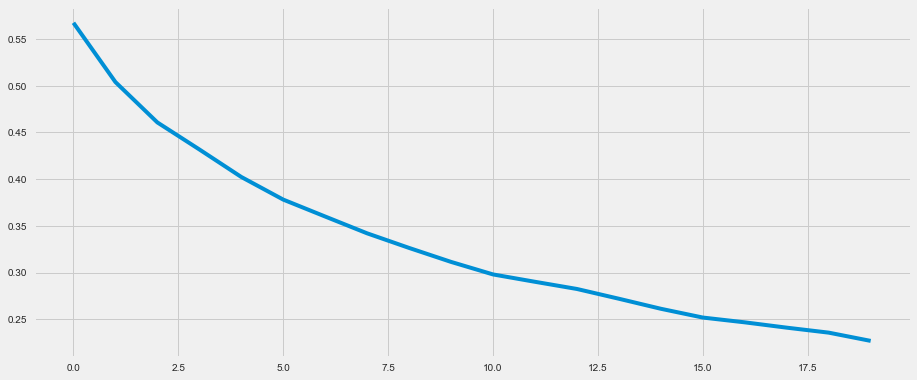

In [155]:
plt.plot(loss_history);